# For testing code, nothing more


In [1]:
import os

# Doc for download https://idr.openmicroscopy.org/about/download.html

S_PATH = "/".join(os.path.realpath("test").split(os.sep)[:-1])

class data_manager:

    def __init__(self, data_dir = None) -> None:
        if data_dir is None:
            self.data_dir = os.path.join(S_PATH, "../data")
            print(f"Data directory is not specified, using default: {self.data_dir}")
        
        # Save file empty file to data directory now
        # TODO: Check if file exists
        #self.data_file = os.path.join(self.data_dir, "test.csv")
        #with open(self.data_file, "w") as f:
        #    f.write("")

    


        pass

    def download_data(self, dataset_name):
        if dataset_name == "METABRIC":
            # Get the command
            command = self.idr_download_command("idr0076")

            # Execute the command
            os.system(command)
        pass

    def preprocess(self, dataset_name):
        pass

    def save_data(self, dataset_name):
        pass

    def load_data(self, dataset_name):
        pass

    def idr_download_command(self, idr_id):
        save_dir = os.path.join(self.data_dir, idr_id)
        return f"ascp -TQ -l40m -P 33001 -i 'config/asperaweb_id_dsa.openssh' {idr_id}@fasp.ebi.ac.uk:. {save_dir}"



In [2]:
d= data_manager()

d.download_data("METABRIC")

Data directory is not specified, using default: /Users/dgermen/Documents/GCN Clinical Clinical Outcome Prediction/GNNClinicalOutcomePrediction/bin/../data


sh: ascp: command not found


# Data merging for METABRIC

In [3]:
import pandas as pd
import time

# Read the first file
clinical_data = pd.read_csv('../data/METABRIC/brca_metabric_clinical_data.tsv', sep='\t')

# Read the second file
single_cell_data = pd.read_csv('../data/METABRIC/single_cell_data.csv')

# Record the time before the merge
start_time = time.time()

# Columns representing mean ion counts
mean_ion_count_columns = [
    'HH3_total', 'CK19', 'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin',
    'c_Myc', 'HER2', 'CD3', 'HH3_ph', 'Erk1_2', 'Slug', 'ER', 'PR', 'p53', 'CD44',
    'EpCAM', 'CD45', 'GATA3', 'CD20', 'Beta_catenin', 'CAIX', 'E_cadherin', 'Ki67',
    'EGFR', 'pS6', 'Sox9', 'vWF_CD31', 'pmTOR', 'CK7', 'panCK', 'c_PARP_c_Casp3',
    'DNA1', 'DNA2', 'H3K27me3', 'CK5', 'Fibronectin'
]

# Dictionary to keep track of renamed columns
renamed_columns_mapping = {}

# Rename the mean ion count columns
counter = 1 
for col in mean_ion_count_columns:
    new_name = f'Intensity_MeanIntensity_FullStack_c{counter}'
    renamed_columns_mapping[col] = new_name
    single_cell_data.rename(columns={col: new_name}, inplace=True)
    counter += 1

# Merge the two dataframes on 'Sample ID' and 'metabricId'
merged_data = single_cell_data.merge(clinical_data, left_on='metabricId', right_on='Sample ID', how='inner')

# Rename the other columns
columns_to_rename = {
    'Sample ID': 'PID',
    'Age at Diagnosis': 'age',
    'Neoplasm Histologic Grade': 'grade',
    'Tumor Size': 'tumor_size',
    'Chemotherapy': 'treatment',
    'Cancer Type Detailed': 'clinical_type',
    'Overall Survival (Months)': 'OSmonth',
    'Nottingham prognostic index': 'DiseaseStage',
    'Patient\'s Vital Status': 'diseasestatus',
    'Relapse Free Status (Months)': 'DFSmonth',
    'Cancer Type': 'description',

}

merged_data.rename(columns=columns_to_rename, inplace=True)

# Select the columns you want to keep in the final file
desired_columns = [
    'ImageNumber', 'ObjectNumber', 'Location_Center_X', 'Location_Center_Y'
] + [f'Intensity_MeanIntensity_FullStack_c{i}' for i in range(1, len(mean_ion_count_columns))] + [
    'PID', 'grade', 'tumor_size', 'age', 'treatment', 'DiseaseStage',
    'diseasestatus', 'clinical_type', 'DFSmonth', 'OSmonth', 'Tumor_Size',
]

final_data = merged_data[desired_columns]

# Record the time after the merge
end_time = time.time()

# Calculate the time taken for the merge
time_taken = end_time - start_time

# Save the mapping to a file for future reference
with open('../data/METABRIC/merged_data_mapping.txt', 'w') as f:
    for key, value in renamed_columns_mapping.items():
        f.write(f"{key} -> {value}\n")

# Save the merged dataframe to a new CSV file
final_data.to_csv('../data/METABRIC/merged_data.csv', index=False)

print(f"The merging process took {time_taken} seconds")


The merging process took 1.0512261390686035 seconds


In [4]:
# View head of merged data
final_data.head()

,ImageNumber,ObjectNumber,Location_Center_X,Location_Center_Y,Intensity_MeanIntensity_FullStack_c1,Intensity_MeanIntensity_FullStack_c2,Intensity_MeanIntensity_FullStack_c3,Intensity_MeanIntensity_FullStack_c4,Intensity_MeanIntensity_FullStack_c5,Intensity_MeanIntensity_FullStack_c6,...,PID,grade,tumor_size,age,treatment,DiseaseStage,diseasestatus,clinical_type,DFSmonth,OSmonth
0,527,1,161.83333,6.000000,1.058000,0.000000,0.000000,0.000000,0.618000,0.000000,...,MB-0000,3.0,22.0,75.65,NO,6.044,Living,Breast Invasive Ductal Carcinoma,138.65,140.5
1,527,2,177.30435,15.539130,0.889243,0.166252,0.166487,0.109148,0.071443,0.026087,...,MB-0000,3.0,22.0,75.65,NO,6.044,Living,Breast Invasive Ductal Carcinoma,138.65,140.5
2,527,3,293.51898,19.886076,0.861557,0.150873,0.099861,0.064506,0.025316,0.063747,...,MB-0000,3.0,22.0,75.65,NO,6.044,Living,Breast Invasive Ductal Carcinoma,138.65,140.5
3,527,4,165.04347,22.210144,1.746239,0.069159,0.043478,0.021739,0.623623,0.014493,...,MB-0000,3.0,22.0,75.65,NO,6.044,Living,Breast Invasive Ductal Carcinoma,138.65,140.5
4,527,5,108.88095,28.523809,0.979274,0.144429,0.125500,0.067714,0.028940,0.057381,...,MB-0000,3.0,22.0,75.65,NO,6.044,Living,Breast Invasive Ductal Carcinoma,138.65,140.5


In [5]:
# Get average for DFSmonth and OSmonth
print(f"Average DFSmonth: {final_data['DFSmonth'].mean()}")
print(f"Average OSmonth: {final_data['OSmonth'].mean()}")

# Count disease status
final_data['diseasestatus'].value_counts()

# Group by PID and print DFSmonth and OSmonth averages and count disease status
grouped_data = final_data.groupby('PID')
print(f"Average DFSmonth: {grouped_data['DFSmonth'].mean().mean()}")
print(f"Average OSmonth: {grouped_data['OSmonth'].mean().mean()}")
print(f"Count disease status: {grouped_data['diseasestatus'].value_counts()}")


Average DFSmonth: 86.03868933280224
Average OSmonth: 94.57488861993205
Average DFSmonth: 87.37644444444445
Average OSmonth: 95.43036303746783
Count disease status: PID      diseasestatus       
MB-0000  Living                   256
MB-0002  Living                  1111
MB-0005  Died of Disease         1088
MB-0010  Died of Disease         1077
MB-0014  Living                  1569
                                 ... 
MB-0897  Died of Other Causes     927
MB-0899  Living                  1096
MB-0901  Living                  1625
MB-0904  Died of Other Causes     786
MB-0906  Died of Other Causes     750
Name: diseasestatus, Length: 404, dtype: int64


In [6]:
# Print all categorical columns' possible values
for col in final_data.columns:
    if final_data[col].dtype == 'object':
        print(f"{col}: {final_data[col].unique()}")

PID: ['MB-0000' 'MB-0002' 'MB-0005' 'MB-0010' 'MB-0014' 'MB-0020' 'MB-0022'
 'MB-0028' 'MB-0035' 'MB-0045' 'MB-0050' 'MB-0060' 'MB-0064' 'MB-0081'
 'MB-0095' 'MB-0099' 'MB-0107' 'MB-0109' 'MB-0111' 'MB-0112' 'MB-0114'
 'MB-0115' 'MB-0116' 'MB-0117' 'MB-0119' 'MB-0120' 'MB-0121' 'MB-0122'
 'MB-0123' 'MB-0124' 'MB-0126' 'MB-0127' 'MB-0128' 'MB-0130' 'MB-0131'
 'MB-0133' 'MB-0134' 'MB-0135' 'MB-0136' 'MB-0138' 'MB-0139' 'MB-0140'
 'MB-0142' 'MB-0143' 'MB-0144' 'MB-0145' 'MB-0150' 'MB-0151' 'MB-0152'
 'MB-0153' 'MB-0154' 'MB-0158' 'MB-0162' 'MB-0163' 'MB-0164' 'MB-0165'
 'MB-0166' 'MB-0167' 'MB-0168' 'MB-0169' 'MB-0170' 'MB-0173' 'MB-0174'
 'MB-0175' 'MB-0176' 'MB-0177' 'MB-0178' 'MB-0179' 'MB-0180' 'MB-0181'
 'MB-0184' 'MB-0185' 'MB-0188' 'MB-0189' 'MB-0191' 'MB-0192' 'MB-0193'
 'MB-0194' 'MB-0195' 'MB-0197' 'MB-0198' 'MB-0199' 'MB-0200' 'MB-0201'
 'MB-0202' 'MB-0203' 'MB-0204' 'MB-0205' 'MB-0206' 'MB-0214' 'MB-0218'
 'MB-0220' 'MB-0221' 'MB-0222' 'MB-0223' 'MB-0224' 'MB-0225' 'MB-0227'
 

In [7]:
# Get a summary of basel_zurich data data/raw/basel_zurich_preprocessed_compact_dataset.csv
basel_zurich_data = pd.read_csv('../data/raw/basel_zurich_preprocessed_compact_dataset.csv')
basel_zurich_data.describe()

/var/folders/k2/mmnsl0v1443297g72q3p30cw0000gn/T/ipykernel_9925/1283039991.py:2: DtypeWarning: Columns (38,41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  basel_zurich_data = pd.read_csv('../data/raw/basel_zurich_preprocessed_compact_dataset.csv')


,ImageNumber,ObjectNumber,Location_Center_X,Location_Center_Y,Intensity_MeanIntensity_FullStack_c12,Intensity_MeanIntensity_FullStack_c13,Intensity_MeanIntensity_FullStack_c14,Intensity_MeanIntensity_FullStack_c15,Intensity_MeanIntensity_FullStack_c16,Intensity_MeanIntensity_FullStack_c17,...,Intensity_MeanIntensity_FullStack_c44,Intensity_MeanIntensity_FullStack_c45,Intensity_MeanIntensity_FullStack_c46,Intensity_MeanIntensity_FullStack_c47,Intensity_MeanIntensity_FullStack_c9,PID,tumor_size,age,DFSmonth,OSmonth
count,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,...,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,1.271764e+06,1.203600e+06,1.271764e+06,844498.000000,844498.000000
mean,3.155191e+02,1.368791e+03,3.409851e+02,3.262661e+02,7.426104e-01,2.715571e-01,6.720380e+00,1.151325e+00,2.040252e+00,3.942233e-01,...,1.449204e+00,5.612840e-01,1.188977e+01,9.428397e-01,8.475248e+00,1.054268e+02,2.630263e+01,5.885980e+01,70.501565,80.568871
std,2.005689e+02,1.119528e+03,2.118995e+02,2.040654e+02,7.598095e-01,1.289127e+00,8.186863e+00,4.210309e+00,4.248771e+00,4.677216e-01,...,2.347908e+00,1.881861e+00,2.077059e+01,8.593114e-01,7.898275e+00,8.261360e+01,1.569561e+01,1.276201e+01,50.222945,50.304711
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.600000e+01,0.000000,0.000000
25%,1.460000e+02,4.990000e+02,1.633310e+02,1.550000e+02,3.559145e-01,7.602116e-02,2.013068e+00,1.854684e-01,1.340305e-01,1.505500e-01,...,5.233312e-01,4.150355e-02,1.829462e-01,4.380469e-01,3.315546e+00,3.600000e+01,1.500000e+01,5.100000e+01,28.000000,44.000000
50%,2.970000e+02,1.107000e+03,3.259701e+02,3.111746e+02,5.538271e-01,1.165789e-01,4.467477e+00,3.480355e-01,3.839080e-01,2.734318e-01,...,8.982323e-01,9.563944e-02,2.558617e+00,7.755922e-01,6.272789e+00,7.500000e+01,2.200000e+01,5.700000e+01,65.000000,71.000000
75%,4.530000e+02,1.953000e+03,4.931736e+02,4.728162e+02,8.782674e-01,1.764151e-01,8.720362e+00,1.042199e+00,2.070502e+00,4.957031e-01,...,1.583462e+00,3.000000e-01,1.534675e+01,1.225241e+00,1.107491e+01,1.730000e+02,3.200000e+01,6.700000e+01,100.000000,110.000000
max,7.430000e+02,6.940000e+03,1.030250e+03,8.805769e+02,1.617138e+02,2.043989e+02,1.125510e+03,2.848142e+03,7.509167e+02,4.520925e+01,...,1.117817e+02,1.322381e+02,6.604926e+02,1.081832e+02,2.381960e+02,2.850000e+02,1.250000e+02,9.200000e+01,195.000000,233.000000


In [8]:
# Summarize merged data
final_data.describe()

,ImageNumber,ObjectNumber,Location_Center_X,Location_Center_Y,Intensity_MeanIntensity_FullStack_c1,Intensity_MeanIntensity_FullStack_c2,Intensity_MeanIntensity_FullStack_c3,Intensity_MeanIntensity_FullStack_c4,Intensity_MeanIntensity_FullStack_c5,Intensity_MeanIntensity_FullStack_c6,...,Intensity_MeanIntensity_FullStack_c35,Intensity_MeanIntensity_FullStack_c36,Intensity_MeanIntensity_FullStack_c37,Intensity_MeanIntensity_FullStack_c38,grade,tumor_size,age,DiseaseStage,DFSmonth,OSmonth
count,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,...,406686.000000,406686.000000,406686.000000,406686.000000,397606.000000,403951.000000,406686.000000,406686.000000,406686.000000,406039.000000
mean,279.655845,651.489237,255.774012,251.064284,5.257069,0.823886,2.675091,0.318922,0.354454,0.143307,...,29.436310,52.992880,1.064660,0.467633,2.486044,28.632656,63.350662,4.310474,86.038689,94.574889
std,158.813908,469.132391,146.330157,144.626679,3.520848,1.501242,5.688057,0.414753,1.098554,0.644101,...,12.015900,21.990631,1.807018,1.247682,0.620399,16.396406,13.848032,1.202610,49.964710,53.408298
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,26.360000,1.000000,1.220000,1.233333
25%,152.000000,273.000000,131.965545,129.105205,2.844834,0.168220,0.139070,0.139620,0.080059,0.039109,...,21.568992,38.596342,0.581594,0.163747,2.000000,20.000000,52.430000,4.020000,43.650000,49.233333
50%,274.000000,571.000000,250.066010,244.333330,4.499081,0.317529,0.508428,0.246356,0.148465,0.072727,...,27.150737,48.816862,0.862976,0.288096,3.000000,25.000000,61.890000,4.060000,84.840000,94.733333
75%,417.000000,949.000000,373.307052,366.933620,6.813150,0.799879,2.722838,0.407725,0.284228,0.120667,...,34.642201,62.537992,1.285223,0.500799,3.000000,33.000000,74.630000,5.066000,121.090000,131.066667
max,555.000000,3256.000000,812.700010,739.416690,167.044970,47.120029,155.391950,179.557360,87.484306,40.540565,...,208.737750,377.375090,677.185670,295.227360,3.000000,180.000000,96.290000,6.360000,210.690000,337.033333


In [9]:
# Print all categorical columns' possible values
for col in basel_zurich_data.columns:
    if basel_zurich_data[col].dtype == 'object':
        print(f"{col}: {basel_zurich_data[col].unique()}")

grade: [3 1 2 '3' '2' 'METASTASIS' '1']
treatment: [nan '[]' 'FIXED']
DiseaseStage: ['1. Primary Dx' '17. Primary Dx' '19. Primary Dx' '71. Primary Dx'
 '72. Primary Dx' '15. Primary Dx' '23. Primary Dx' '12. Primary Dx'
 '3. Primary Dx' '35. Primary Dx' '25. Primary Dx' '28. Primary Dx'
 '51. Primary Dx' '50. Primary Dx' '67. Primary Dx' '68. Primary Dx'
 '66. Primary Dx' '61. Primary Dx' '60. Primary Dx' '76. Primary Dx'
 '29. Primary Dx' '27. Primary Dx' '26. Primary Dx' '20. Primary Dx'
 '11. Primary Dx' '30. Primary Dx' '42. Primary Dx' '41. Primary Dx'
 '40. Primary Dx' '59. Primary Dx' '58. Primary Dx' '57. Primary Dx'
 '79. Primary Dx' '44. Primary Dx' '56. Primary Dx' '39. Primary Dx'
 '38. Primary Dx' '24. Primary Dx' '7. Primary Dx' '78. Primary Dx'
 '88. Primary Dx' '87. Primary Dx' '18. Primary Dx' '85. Primary Dx'
 '21. Primary Dx' '22. Primary Dx' '75. Primary Dx' '77. Primary Dx'
 '4. Primary Dx' '93. Primary Dx' '10. Primary Dx' '80. Primary Dx'
 '82. Primary Dx' '99. 

In [10]:
# Summerize the data for brca_metabric_clinical_data.tsv
clinical_data.describe()

,Age at Diagnosis,Cohort,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Relapse Free Status (Months),Number of Samples Per Patient,TMB (nonsynonymous),Tumor Size,Tumor Stage
count,2498.000000,2498.000000,2388.000000,2243.000000,2358.000000,2287.000000,1981.000000,2388.000000,2509.0,2509.000000,2360.000000,1788.000000
mean,60.420300,2.900320,2.412060,1.950513,5.590755,4.028787,125.244271,108.842487,1.0,6.849746,26.220093,1.713647
std,13.032997,1.962216,0.649363,4.017774,3.989171,1.189092,76.111772,76.519494,0.0,5.320394,15.370883,0.655307
min,21.930000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000
25%,50.920000,1.000000,2.000000,0.000000,3.000000,3.048000,60.866667,40.560000,1.0,3.922553,17.000000,1.000000
50%,61.110000,3.000000,3.000000,0.000000,5.000000,4.044000,116.466667,99.095000,1.0,6.537589,22.410000,2.000000
75%,70.000000,4.000000,3.000000,2.000000,7.000000,5.040000,185.133333,167.640000,1.0,9.152624,30.000000,2.000000
max,96.290000,9.000000,3.000000,45.000000,81.000000,7.200000,355.200000,384.210000,1.0,104.601416,182.000000,4.000000


In [11]:
# Print all categorical columns' possible values

for col in clinical_data.columns:
    if clinical_data[col].dtype == 'object':
        print(f"{col}: {clinical_data[col].unique()}")

Study ID: ['brca_metabric']
Patient ID: ['MB-0000' 'MB-0002' 'MB-0005' ... 'MTS-T2430' 'MTS-T2431' 'MTS-T2432']
Sample ID: ['MB-0000' 'MB-0002' 'MB-0005' ... 'MTS-T2430' 'MTS-T2431' 'MTS-T2432']
Type of Breast Surgery: ['MASTECTOMY' 'BREAST CONSERVING' nan]
Cancer Type: ['Breast Cancer']
Cancer Type Detailed: ['Breast Invasive Ductal Carcinoma'
 'Breast Mixed Ductal and Lobular Carcinoma'
 'Breast Invasive Lobular Carcinoma' 'Invasive Breast Carcinoma'
 'Breast Invasive Mixed Mucinous Carcinoma' 'Breast Angiosarcoma' 'Breast'
 'Metaplastic Breast Cancer']
Cellularity: [nan 'High' 'Moderate' 'Low']
Chemotherapy: ['NO' 'YES' nan]
Pam50 + Claudin-low subtype: ['claudin-low' 'LumA' 'LumB' 'Normal' nan 'Her2' 'Basal' 'NC']
ER status measured by IHC: ['Positve' 'Negative' nan]
ER Status: ['Positive' 'Negative' nan]
HER2 status measured by SNP6: ['NEUTRAL' 'LOSS' nan 'GAIN' 'UNDEF']
HER2 Status: ['Negative' nan 'Positive']
Tumor Other Histologic Subtype: ['Ductal/NST' 'Mixed' 'Lobular' 'Tubul

In [12]:
# Count nan values in OSmonth in final data

final_data['OSmonth'].isna().sum()


# Count non nan values in OSmonth in final data

final_data['OSmonth'].notna().sum()

# Group by PID and count OSmonth nan values

a = final_data.groupby('PID')['OSmonth'].apply(lambda x: x.isna().sum())

# Show that are not 0

a[a != 0]

PID
MB-0547    647
Name: OSmonth, dtype: int64

In [13]:

# Show diseasestatus = living, group by PID

final_data[final_data['diseasestatus'] == 'Living']['PID'].value_counts()

# Count them all

MB-0184    3438
MB-0501    3085
MB-0081    2951
MB-0513    2319
MB-0394    2264
           ... 
MB-0618      46
MB-0133      44
MB-0478      31
MB-0374      13
MB-0471       7
Name: PID, Length: 218, dtype: int64

#  NEW ANALYSIS


- Find out about living patients in combined file
- 

In [14]:
# Read the merged data
merged_data = pd.read_csv('../data/METABRIC/merged_data.csv')

# Get a summary of the data
merged_data.describe()

,ImageNumber,ObjectNumber,Location_Center_X,Location_Center_Y,Intensity_MeanIntensity_FullStack_c1,Intensity_MeanIntensity_FullStack_c2,Intensity_MeanIntensity_FullStack_c3,Intensity_MeanIntensity_FullStack_c4,Intensity_MeanIntensity_FullStack_c5,Intensity_MeanIntensity_FullStack_c6,...,Intensity_MeanIntensity_FullStack_c35,Intensity_MeanIntensity_FullStack_c36,Intensity_MeanIntensity_FullStack_c37,Intensity_MeanIntensity_FullStack_c38,grade,tumor_size,age,DiseaseStage,DFSmonth,OSmonth
count,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,406686.000000,...,406686.000000,406686.000000,406686.000000,406686.000000,397606.000000,403951.000000,406686.000000,406686.000000,406686.000000,406039.000000
mean,279.655845,651.489237,255.774012,251.064284,5.257069,0.823886,2.675091,0.318922,0.354454,0.143307,...,29.436310,52.992880,1.064660,0.467633,2.486044,28.632656,63.350662,4.310474,86.038689,94.574889
std,158.813908,469.132391,146.330157,144.626679,3.520848,1.501242,5.688057,0.414753,1.098554,0.644101,...,12.015900,21.990631,1.807018,1.247682,0.620399,16.396406,13.848032,1.202610,49.964710,53.408298
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,26.360000,1.000000,1.220000,1.233333
25%,152.000000,273.000000,131.965545,129.105205,2.844834,0.168220,0.139070,0.139620,0.080059,0.039109,...,21.568992,38.596342,0.581594,0.163747,2.000000,20.000000,52.430000,4.020000,43.650000,49.233333
50%,274.000000,571.000000,250.066010,244.333330,4.499081,0.317529,0.508428,0.246356,0.148465,0.072727,...,27.150737,48.816862,0.862976,0.288096,3.000000,25.000000,61.890000,4.060000,84.840000,94.733333
75%,417.000000,949.000000,373.307052,366.933620,6.813150,0.799879,2.722838,0.407725,0.284228,0.120667,...,34.642201,62.537992,1.285223,0.500799,3.000000,33.000000,74.630000,5.066000,121.090000,131.066667
max,555.000000,3256.000000,812.700010,739.416690,167.044970,47.120029,155.391950,179.557360,87.484306,40.540565,...,208.737750,377.375090,677.185670,295.227360,3.000000,180.000000,96.290000,6.360000,210.690000,337.033333


/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


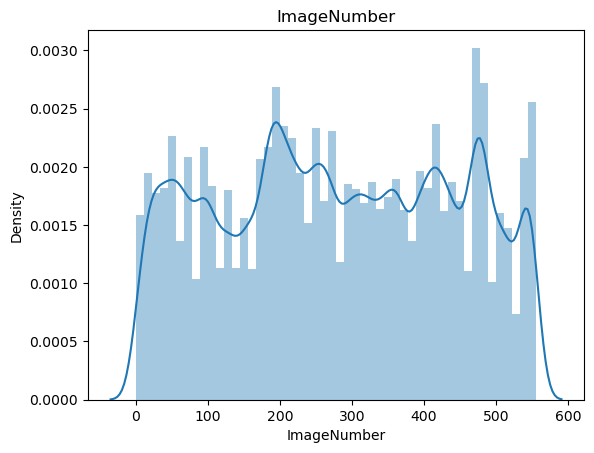

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


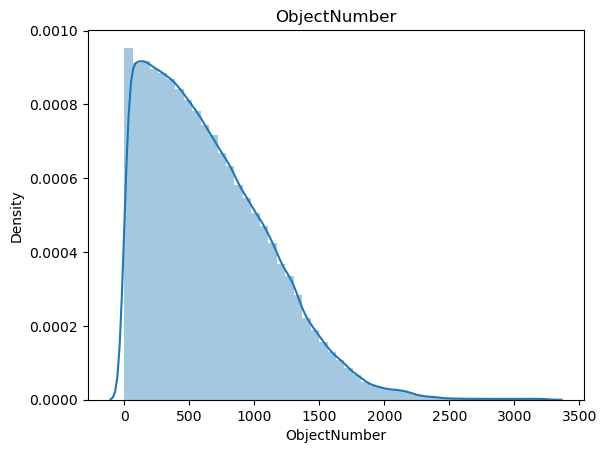

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


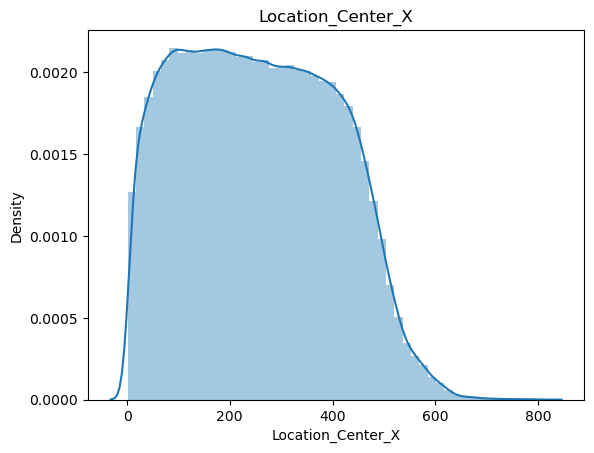

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


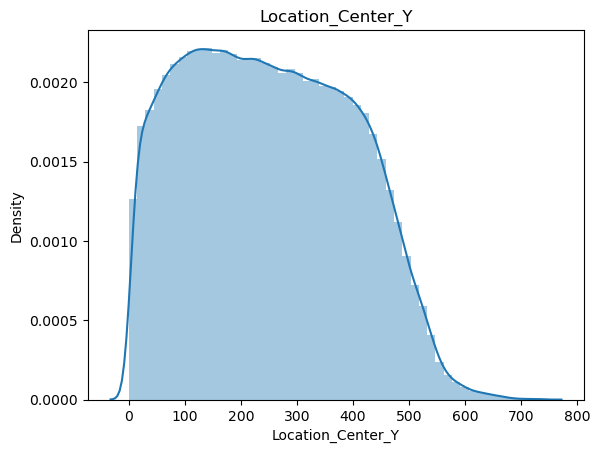

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


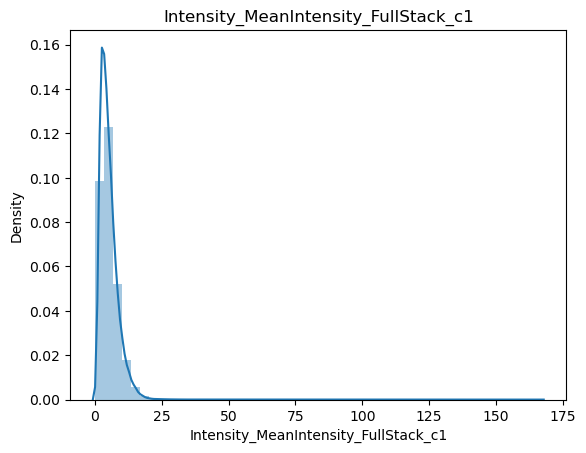

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


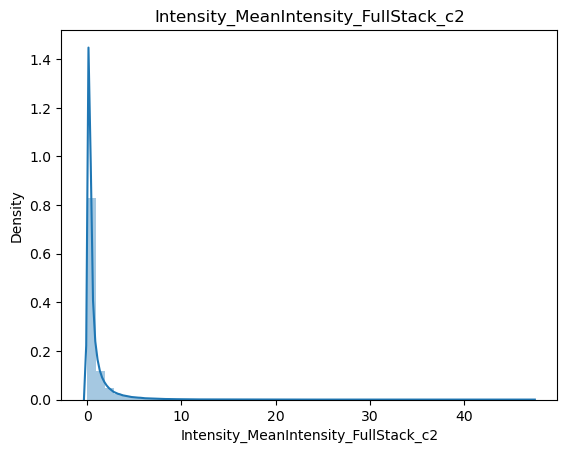

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


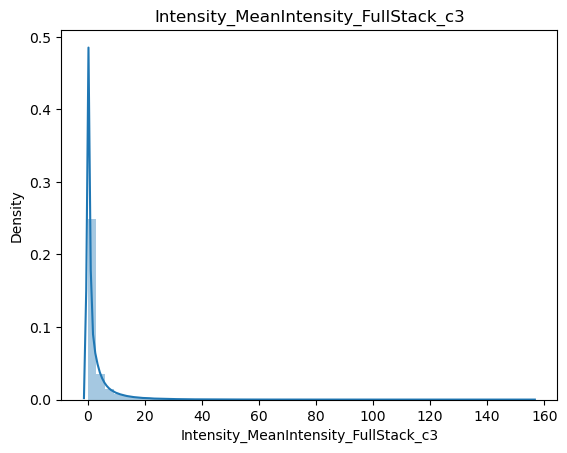

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


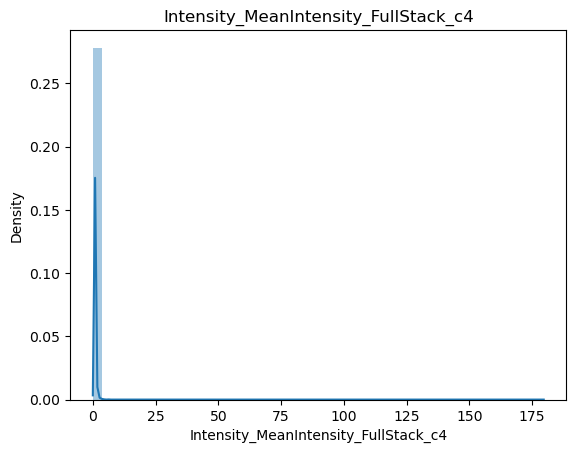

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


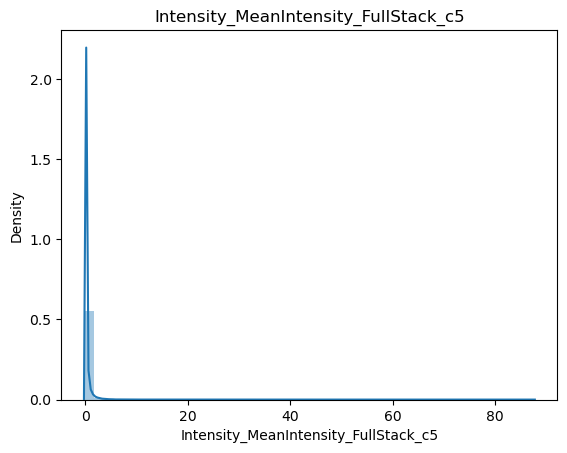

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


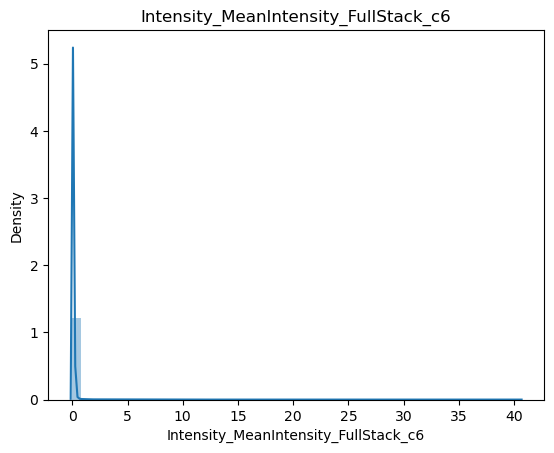

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


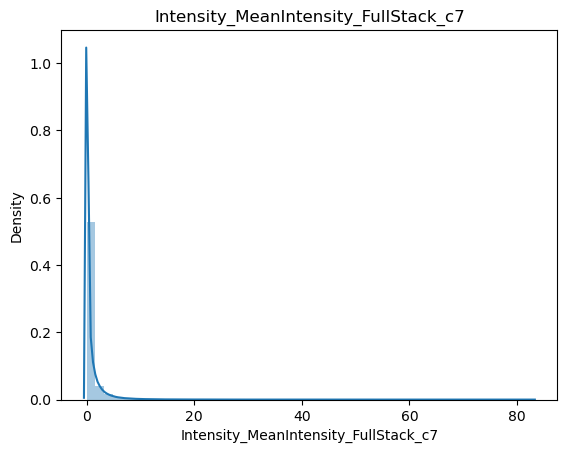

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


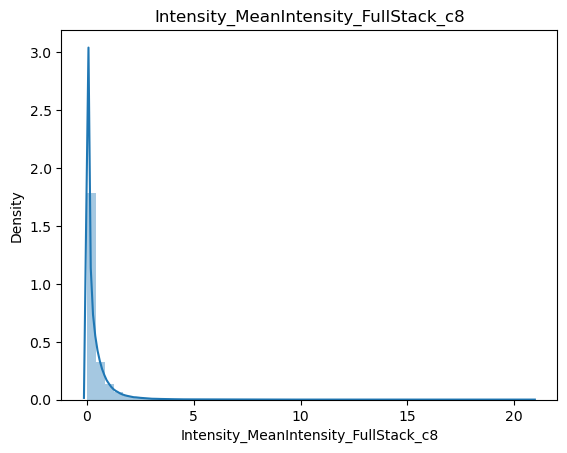

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


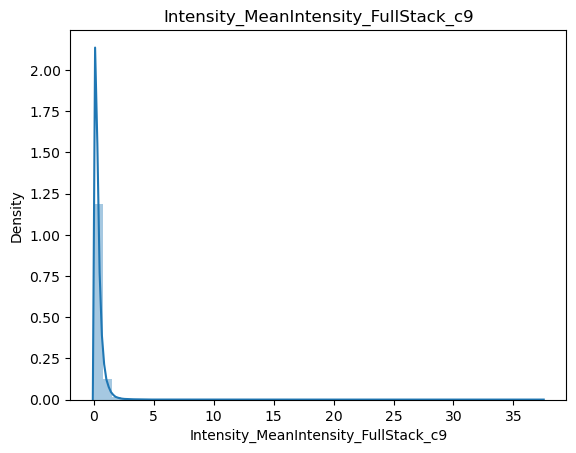

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


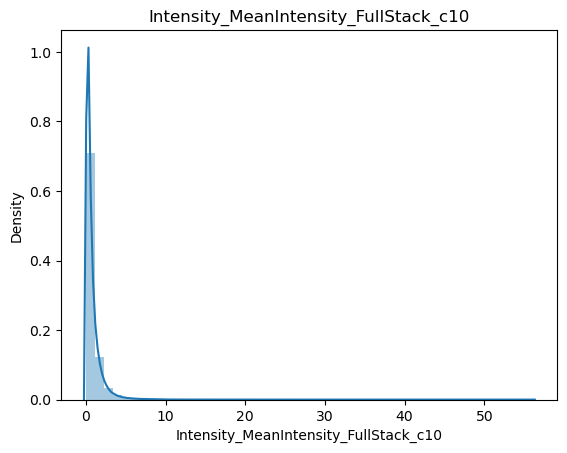

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


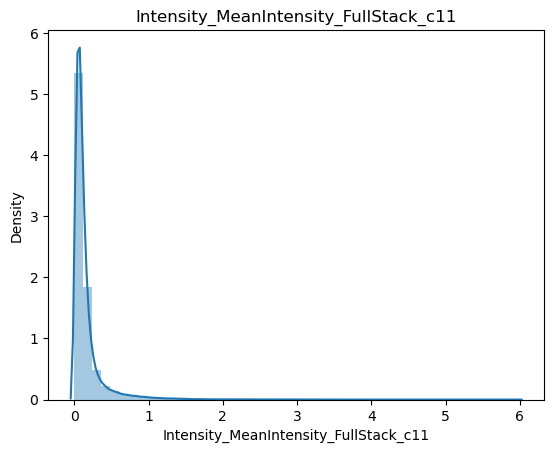

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


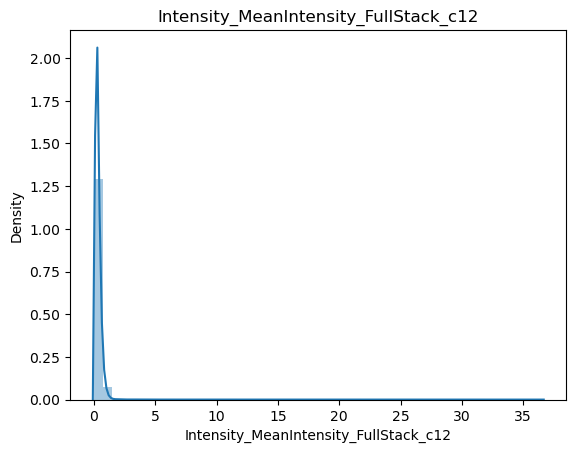

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


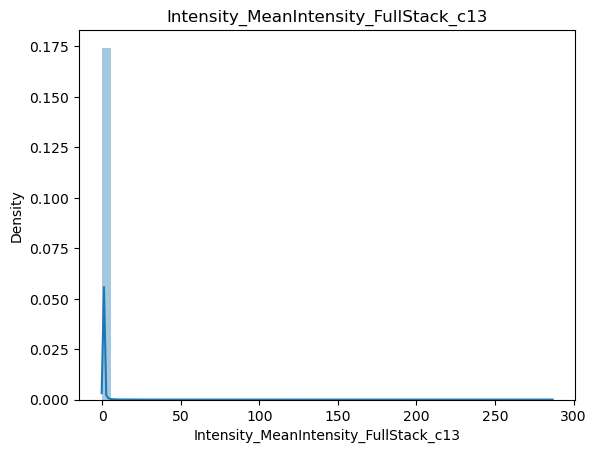

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


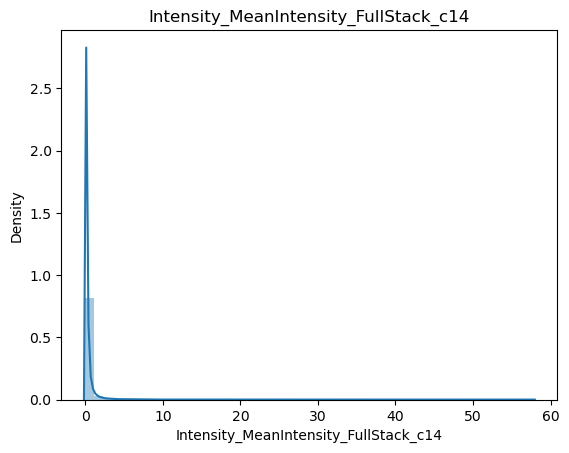

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


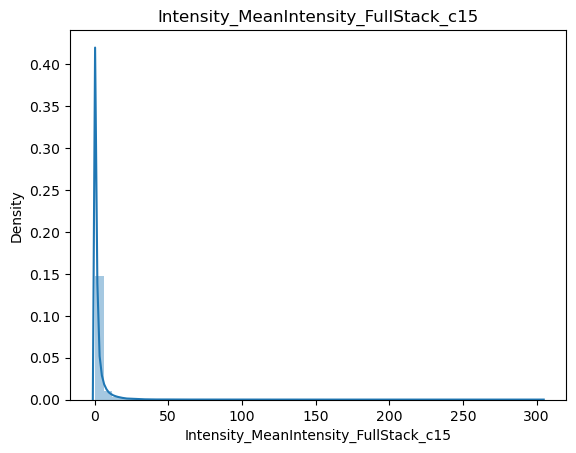

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


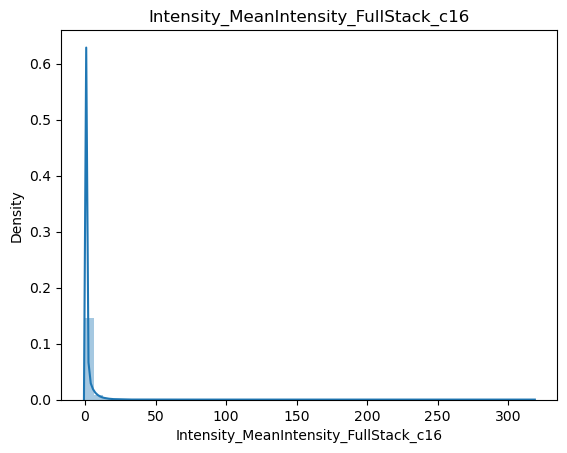

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


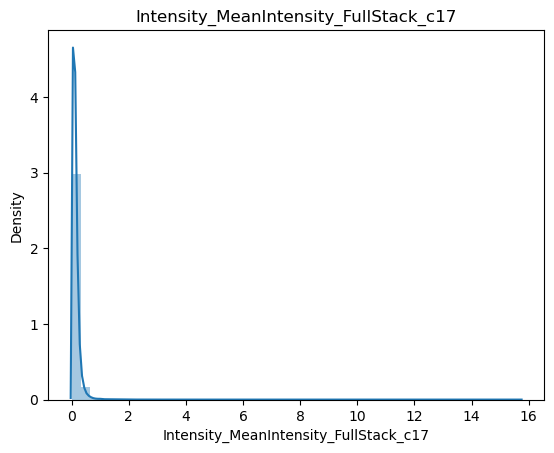

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


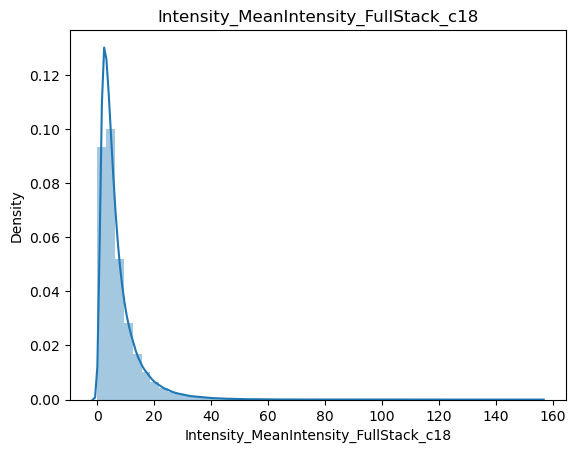

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


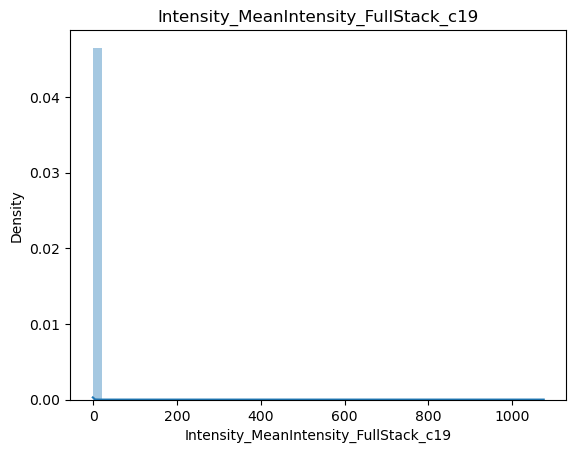

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


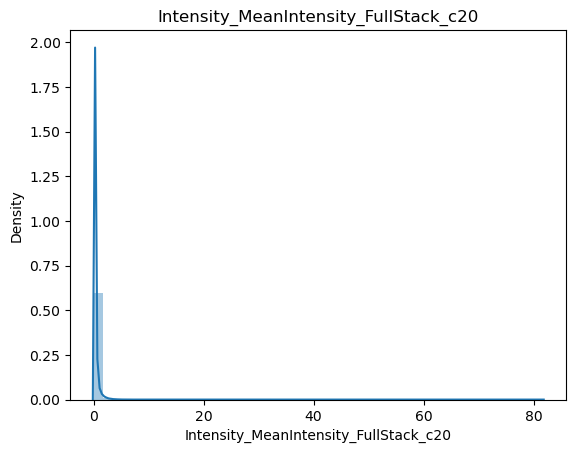

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


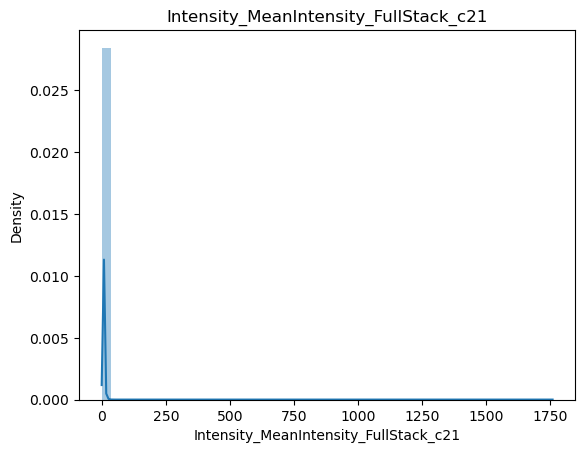

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


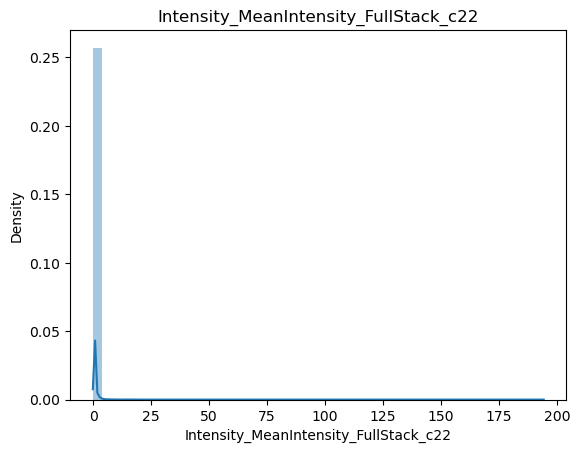

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


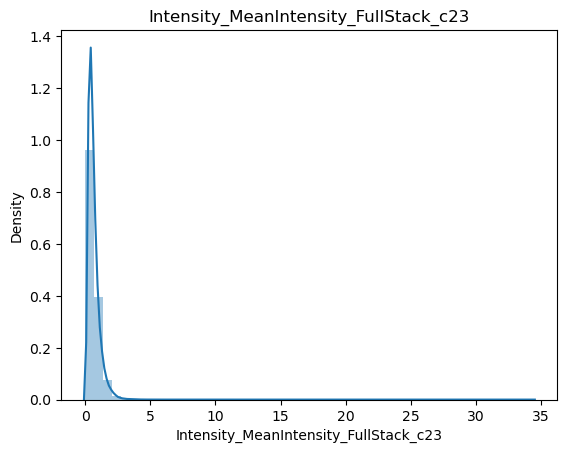

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


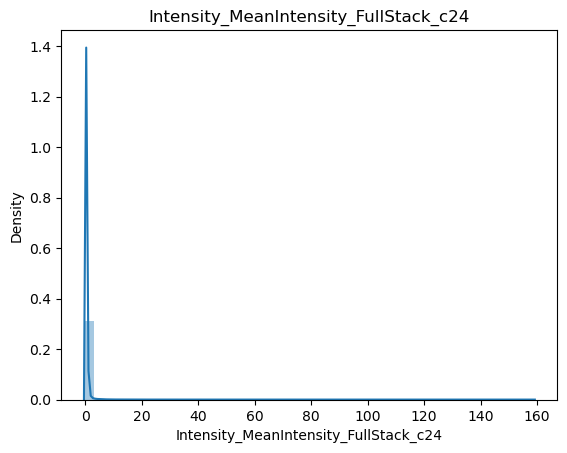

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


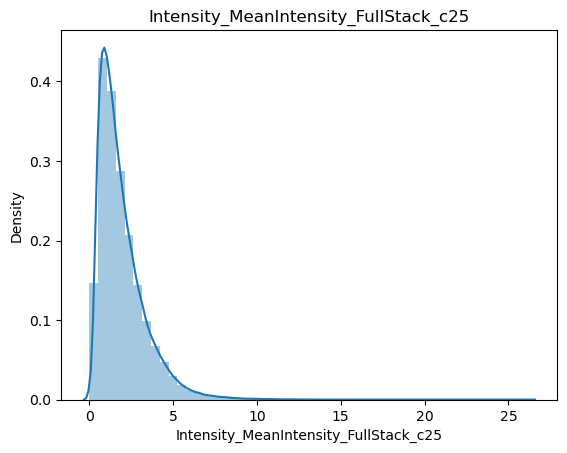

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


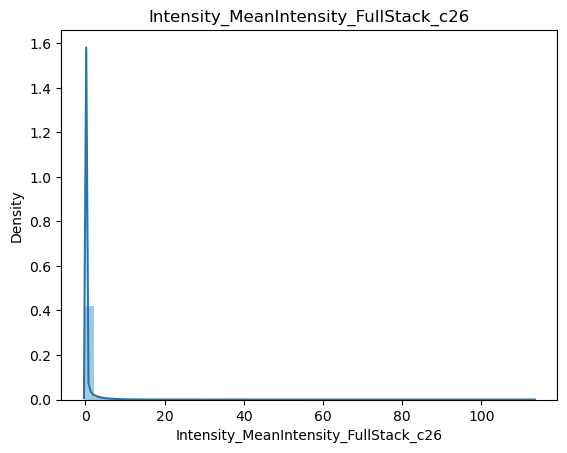

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


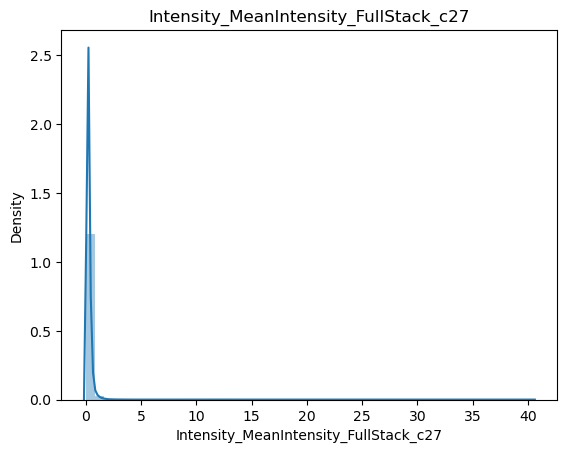

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


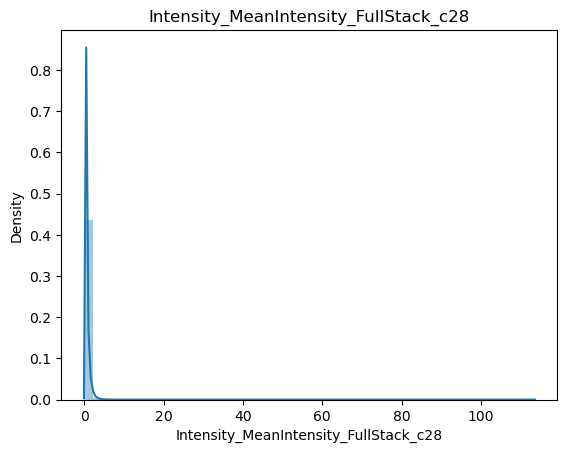

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


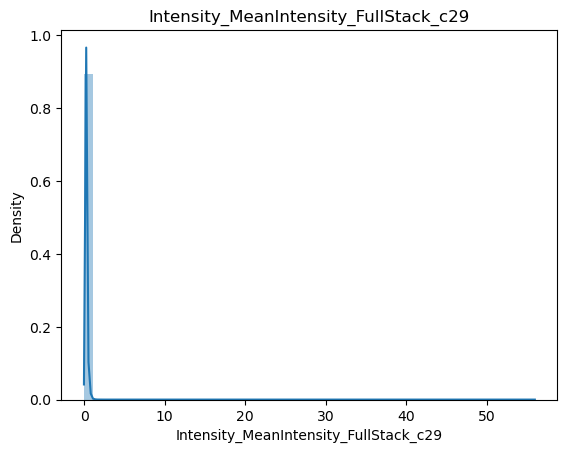

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


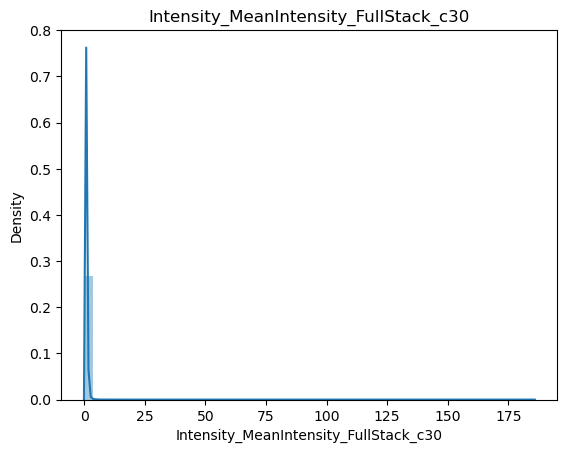

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


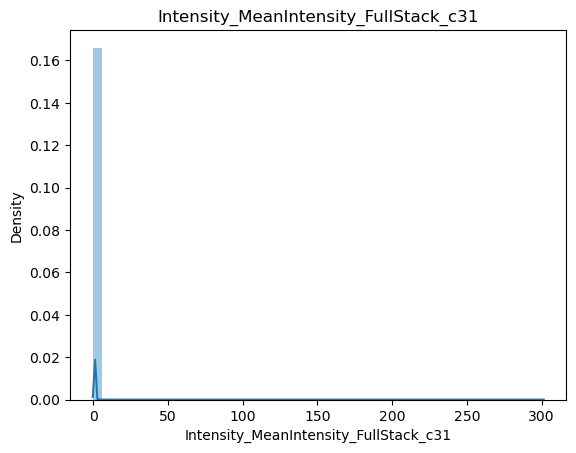

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


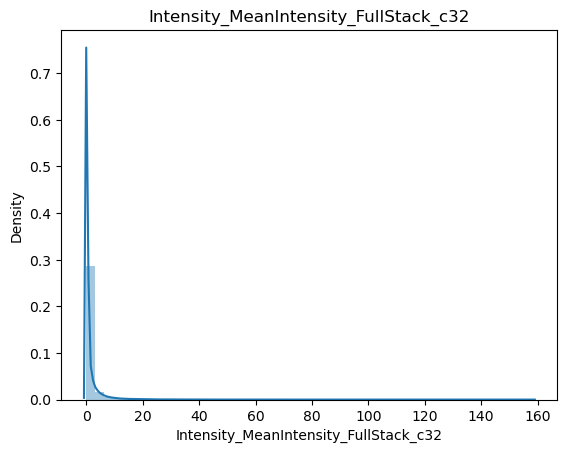

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


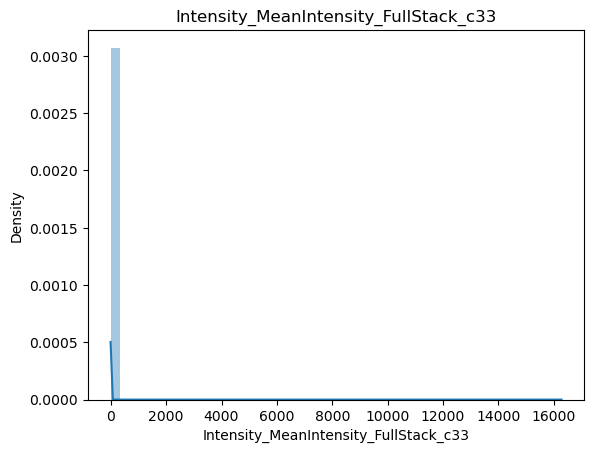

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


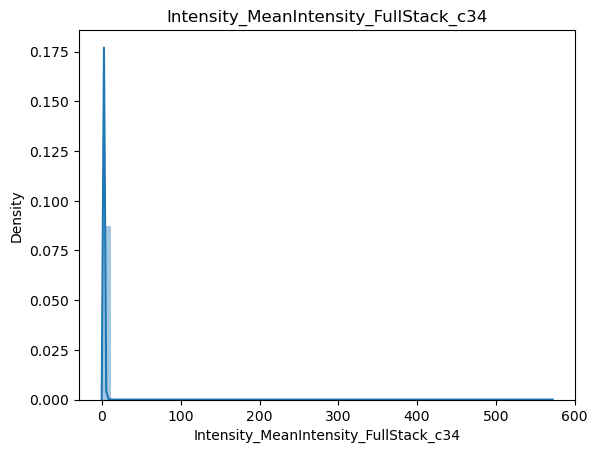

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


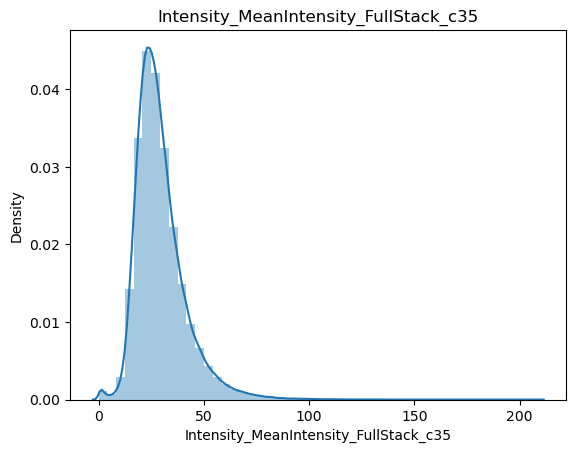

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


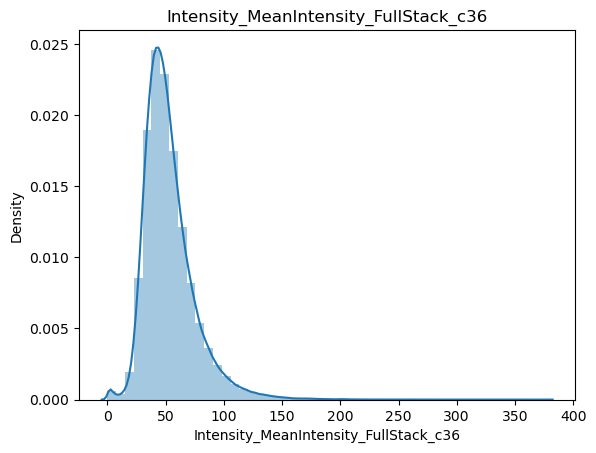

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


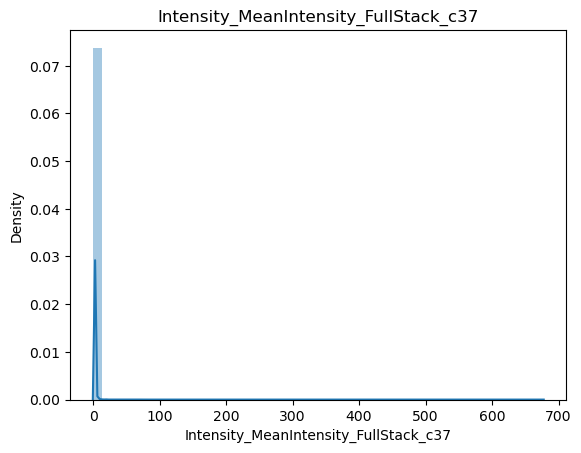

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


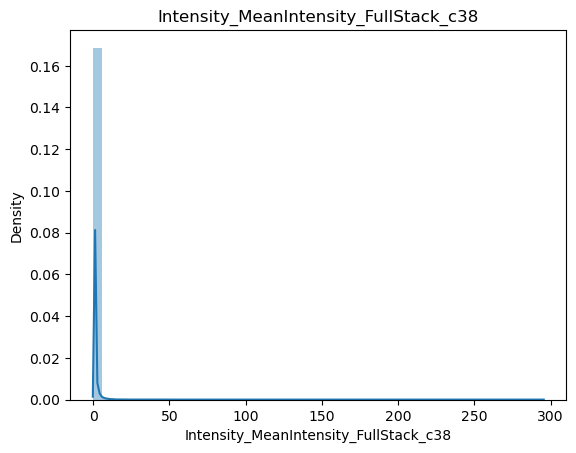

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


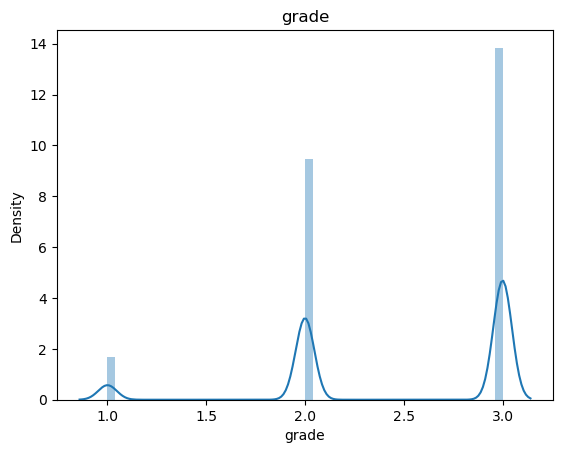

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


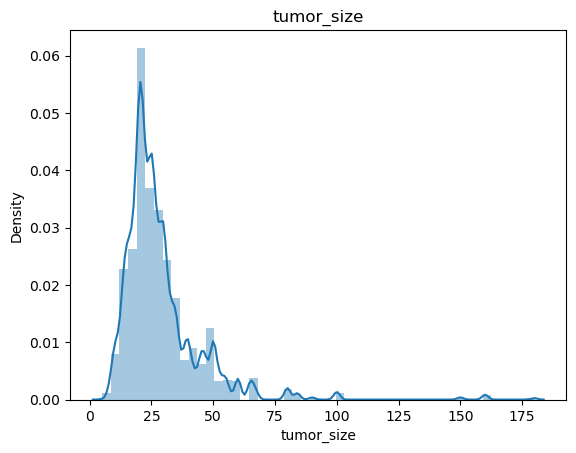

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


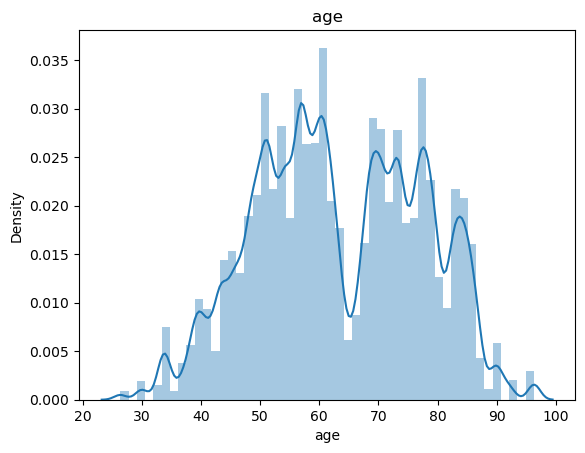

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


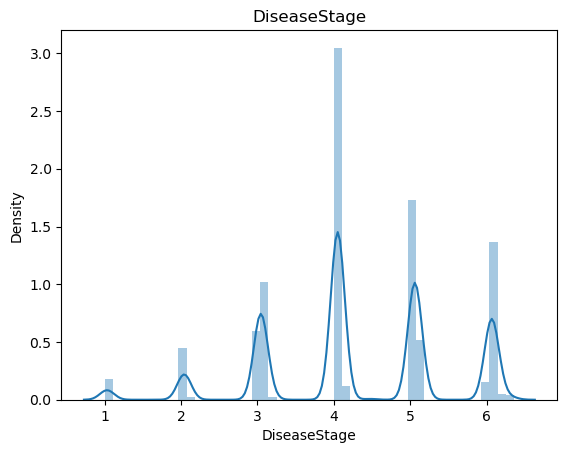

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


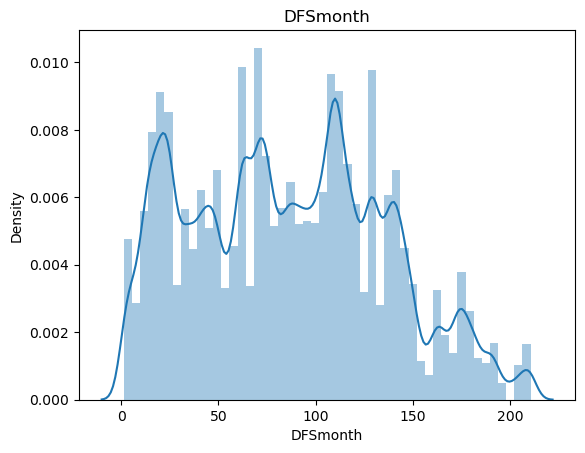

/opt/homebrew/Caskroom/miniconda/base/envs/COPred/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


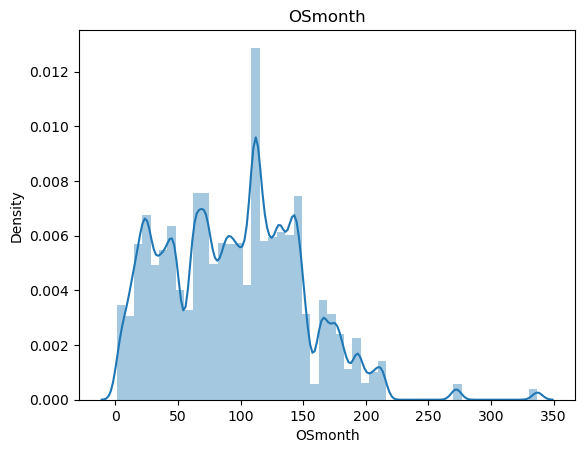

In [15]:
# Name sns not defined, probably package same for plt
import seaborn as sns
import matplotlib.pyplot as plt



# Draw distribution plots for all columns
for col in merged_data.columns:
    if merged_data[col].dtype != 'object':
        sns.distplot(merged_data[col])
        plt.title(col)
        plt.show()



In [16]:
# Draw box plots for categorical columns, show count of categories
for col in merged_data.columns:
    if merged_data[col].dtype == 'object':
        # Print column name, distinguis it from other text
        print(f"Column: {col}")
        print(merged_data[col].value_counts())

Column: PID
MB-0184    3438
MB-0501    3085
MB-0081    2951
MB-0513    2319
MB-0609    2298
           ... 
MB-0618      46
MB-0133      44
MB-0478      31
MB-0374      13
MB-0471       7
Name: PID, Length: 405, dtype: int64
Column: treatment
NO     253163
YES    152876
Name: treatment, dtype: int64
Column: diseasestatus
Living                  211370
Died of Disease         121509
Died of Other Causes     73160
Name: diseasestatus, dtype: int64
Column: clinical_type
Breast Invasive Ductal Carcinoma             323826
Breast Invasive Lobular Carcinoma             33742
Breast Mixed Ductal and Lobular Carcinoma     32685
Breast Invasive Mixed Mucinous Carcinoma       7991
Breast                                         5671
Invasive Breast Carcinoma                      1610
Metaplastic Breast Cancer                      1161
Name: clinical_type, dtype: int64


In [17]:



# Create new dataframe where all data is grouped by PID
df_grouped = merged_data.groupby('PID').mean()




# LASTEST ANALYSIS


In [18]:
# Summary of the merged data

import pandas as pd
import numpy as np




In [20]:
# Count missing values for df_grouped
df_grouped.isnull().sum()

ImageNumber                               0
ObjectNumber                              0
Location_Center_X                         0
Location_Center_Y                         0
Intensity_MeanIntensity_FullStack_c1      0
Intensity_MeanIntensity_FullStack_c2      0
Intensity_MeanIntensity_FullStack_c3      0
Intensity_MeanIntensity_FullStack_c4      0
Intensity_MeanIntensity_FullStack_c5      0
Intensity_MeanIntensity_FullStack_c6      0
Intensity_MeanIntensity_FullStack_c7      0
Intensity_MeanIntensity_FullStack_c8      0
Intensity_MeanIntensity_FullStack_c9      0
Intensity_MeanIntensity_FullStack_c10     0
Intensity_MeanIntensity_FullStack_c11     0
Intensity_MeanIntensity_FullStack_c12     0
Intensity_MeanIntensity_FullStack_c13     0
Intensity_MeanIntensity_FullStack_c14     0
Intensity_MeanIntensity_FullStack_c15     0
Intensity_MeanIntensity_FullStack_c16     0
Intensity_MeanIntensity_FullStack_c17     0
Intensity_MeanIntensity_FullStack_c18     0
Intensity_MeanIntensity_FullStac

In [27]:
# Print columns in clinical_data
print(clinical_data.columns)

# Print Number of Samples Per Patient column
print(clinical_data["Number of Samples Per Patient"])

# Print unique values of Number of Samples Per Patient column
print(clinical_data["Samp"].unique())


Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed',
       'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort',
       'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Number of Samples Per Patient', 'Sample Type', 'Sex',
       '3-Gene classifier subtype', 'TMB (nonsynonymous)', 'Tumor Size',
       'Tumor Stage', 'Patient's Vital Status'],
      dtype='object')
0       1
1       1
2       1


In [31]:
# Number of columns
print(len(clinical_data.columns))
print(len(single_cell_data.columns))

39
48


In [32]:
# Code to read csv

df2 = pd.read_csv('/Users/dgermen/Documents/GCN Clinical Clinical Outcome Prediction/GNNClinicalOutcomePrediction/data/raw/basel_zurich_preprocessed_compact_dataset.csv')
df2.head()

/var/folders/k2/mmnsl0v1443297g72q3p30cw0000gn/T/ipykernel_9925/957544116.py:3: DtypeWarning: Columns (38,41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/Users/dgermen/Documents/GCN Clinical Clinical Outcome Prediction/GNNClinicalOutcomePrediction/data/raw/basel_zurich_preprocessed_compact_dataset.csv')


,ImageNumber,ObjectNumber,Location_Center_X,Location_Center_Y,Intensity_MeanIntensity_FullStack_c12,Intensity_MeanIntensity_FullStack_c13,Intensity_MeanIntensity_FullStack_c14,Intensity_MeanIntensity_FullStack_c15,Intensity_MeanIntensity_FullStack_c16,Intensity_MeanIntensity_FullStack_c17,...,PID,grade,tumor_size,age,treatment,DiseaseStage,diseasestatus,clinical_type,DFSmonth,OSmonth
0,1,1,28.750000,31.955882,0.392426,0.105147,6.854338,0.058824,0.110412,0.021235,...,239,3,14.0,42,NaN,1. Primary Dx,non-tumor,HR+HER2-,128.0,128.0
1,1,2,397.504587,58.284404,0.537394,0.037789,8.518587,0.165688,0.110532,0.107936,...,239,3,14.0,42,NaN,1. Primary Dx,non-tumor,HR+HER2-,128.0,128.0
2,1,3,616.846995,85.284153,0.665907,0.083907,10.748257,0.240066,0.096235,0.083552,...,239,3,14.0,42,NaN,1. Primary Dx,non-tumor,HR+HER2-,128.0,128.0
3,1,4,541.255814,87.627907,0.768698,0.023256,5.732000,0.195814,0.092779,0.139198,...,239,3,14.0,42,NaN,1. Primary Dx,non-tumor,HR+HER2-,128.0,128.0
4,1,5,539.583333,95.944444,0.557870,0.068694,6.733435,0.198472,0.058806,0.145148,...,239,3,14.0,42,NaN,1. Primary Dx,non-tumor,HR+HER2-,128.0,128.0


In [34]:
df2.columns

# Print unique values for each column in df2
# Path: bin/testing.ipynb
for col in df2.columns:
    print(col)
    print(df2[col].unique())

ImageNumber
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 24

In [35]:
df2.columns

Index(['ImageNumber', 'ObjectNumber', 'Location_Center_X', 'Location_Center_Y',
       'Intensity_MeanIntensity_FullStack_c12',
       'Intensity_MeanIntensity_FullStack_c13',
       'Intensity_MeanIntensity_FullStack_c14',
       'Intensity_MeanIntensity_FullStack_c15',
       'Intensity_MeanIntensity_FullStack_c16',
       'Intensity_MeanIntensity_FullStack_c17',
       'Intensity_MeanIntensity_FullStack_c18',
       'Intensity_MeanIntensity_FullStack_c19',
       'Intensity_MeanIntensity_FullStack_c20',
       'Intensity_MeanIntensity_FullStack_c21',
       'Intensity_MeanIntensity_FullStack_c22',
       'Intensity_MeanIntensity_FullStack_c23',
       'Intensity_MeanIntensity_FullStack_c24',
       'Intensity_MeanIntensity_FullStack_c25',
       'Intensity_MeanIntensity_FullStack_c27',
       'Intensity_MeanIntensity_FullStack_c28',
       'Intensity_MeanIntensity_FullStack_c29',
       'Intensity_MeanIntensity_FullStack_c30',
       'Intensity_MeanIntensity_FullStack_c31',
       '

In [39]:
import data_preparation as dp

dp.METABRIC_preprocess()

FileNotFoundError: [Errno 2] No such file or directory: 'data/METABRIC/brca_metabric_clinical_data.tsv'

In [40]:
import data_preparation as dp

dp.METABRIC_preprocess()


FileNotFoundError: [Errno 2] No such file or directory: 'data/METABRIC/brca_metabric_clinical_data.tsv'